In [22]:
import random
import numpy as np
import numpy.typing



# TODO min pyver 3.8

import enum
import typing
import abc


class Orientation(enum.Enum):
    HORIZONTAL = 'horizontal'
    VERTICAL = 'vertical'

class Coordinate(typing.NamedTuple):
    x: float
    y: float

class Dimension(typing.NamedTuple):
    width: float
    height: float

class TextSpec(typing.NamedTuple):
    content: str
    size: float
    rotation: Orientation
    position: Coordinate = None

class BaseCanvas(abc.ABC):
    @property
    @abc.abstractmethod
    def dimension(self) -> Dimension:
        raise NotImplementedError()

    @property
    @abc.abstractmethod
    def data_bilevel(self) -> np.typing.ArrayLike:
        raise NotImplementedError()

    @abc.abstractmethod
    def text(self, text_spec: TextSpec) -> Dimension:
        raise NotImplementedError()


def rgba_to_rgb(
    rgba: np.typing.ArrayLike, 
    rgb_background: np.typing.ArrayLike
) -> np.typing.NDArray:
    rgba = np.asarray(rgba, dtype=np.uint8)

    r, g, b, a = rgba.T
    r_, g_, b_, a_ = *rgb_background, a / 255.

    rgb = (a_ * (r, g, b) + (1 - a_) * (r, g, b)).T
    return rgb.astype(np.uint8)

def rgb_to_bilevel(
    rgb: np.typing.ArrayLike, 
    rgb_background: np.typing.ArrayLike
) -> np.typing.NDArray:
    rgb, rgb_background = map(
        lambda x: np.asarray(x, dtype=np.uint8), 
        (rgb, rgb_background)
    )

    return (rgb == rgb_background).all(axis=-1)


import matplotlib as mpl
import matplotlib.pyplot as plt

import io





class Canvas(BaseCanvas):
    def __init__(
        self, 
        #backend: typing.Type[mpl.figure.FigureCanvasBase]=mpl.backends.backend_agg.FigureCanvas,
        figure: mpl.figure.FigureBase=None
    ):
        self._figure = figure
        #self._base = backend(figure=figure)

    @property
    def _base(self):
        return self._figure.canvas

    #@property
    #def _figure(self):
    #    return self._base.figure

    @property
    def _background_rgb(self) -> np.typing.ArrayLike:
        r, g, b, _ = np.multiply(self._figure.get_facecolor(), 255).astype(np.uint8)
        return r, g, b

    @property
    def dimension(self) -> Dimension:
        _, _, width, height = self._figure.get_window_extent(
            renderer=self._base.get_renderer()
        ).bounds
        return Dimension(width, height)

    @property
    def data_rgba(self) -> np.typing.ArrayLike:
        region = self._base.copy_from_bbox(self._figure.bbox)
        return np.asarray(region, dtype=np.uint8)

    @property
    def data_rgb(self) -> np.typing.ArrayLike:
        return rgba_to_rgb(self.data_rgba, rgb_background=self._background_rgb)

    @property
    def data_bilevel(self) -> np.typing.ArrayLike:
        return rgb_to_bilevel(self.data_rgb, rgb_background=self._background_rgb)

    def text(self, text_spec: TextSpec) -> Dimension:
        def _draw(f: mpl.figure.Figure, render: bool):
            if not render:
                return f.draw_without_rendering()
            return f.draw(renderer=f.canvas.get_renderer())

        def _get_extent(t: mpl.text.Text):
            b = t.get_bbox_patch()
            if b is not None:
                return b.get_window_extent()
            return t.get_window_extent(
                renderer=t.get_figure().canvas.get_renderer()
            )

        pos = text_spec.position or Coordinate(0, 0)
        t = self._figure.add_artist(
            mpl.text.Text(
                x=pos.x, y=pos.y,
                text=text_spec.content,
                size=text_spec.size,
                transform=None
            )            
        )

        _draw(self._figure, render=True)
        
        _, _, width, height = _get_extent(t).bounds

        # hidden
        if text_spec.position is None:
            t.remove()
            _draw(self._figure, render=True)

        return Dimension(width, height)





class OccupancyMap(object):
    def __init__(
        self, 
        canvas: BaseCanvas, 
        mask: typing.Union[np.typing.ArrayLike, None]=None
    ):
        self._canvas = canvas
        self._mask = mask

    @property
    def canvas(self) -> BaseCanvas:
        return self._canvas

    @property
    def data(self) -> np.typing.ArrayLike:
        res = np.asarray(self.canvas.data_bilevel, dtype=bool)
        if self._mask is not None:
            res += self._mask
        return res

    def query_position(
        self, 
        block_dimension: Dimension
    ) -> typing.Iterator[Coordinate]:
        x_block, y_block = block_dimension
        data = self.data
        x, y = np.shape(data)

        # count how many possible locations
        for i in range(x - x_block):
            for j in range(y - y_block):
                if (
                    data[i, j] + data[i + x_block, j + y_block]
                        == data[i, j + y_block] + data[i + x_block, j]
                ):
                    yield Coordinate(i, j)

    def sample_position(
        self, 
        block_dimension: Dimension, 
        random_state: random.Random
    ) -> Coordinate:
        for x in self.query_position(block_dimension):
            if random_state.choice((True, False)):
                return x

class TextPlacement:
    def __init__(self, 
        canvas: BaseCanvas, 
        occupancy: OccupancyMap, 
        random_state: random.Random
    ):
        self.canvas = canvas
        self.occupancy = occupancy
        self.random_state = random_state

    def add(
        self, 
        text: str, 
        size_range: typing.Tuple[float, float], 
        size_step: float, 
        prefer_horizontal: float
    ) -> TextSpec:
        random_state = self.random_state
        canvas = self.canvas
        occupancy = self.occupancy
        size_min, size_max = size_range

        def _impl(size: float, rotations):
            if size is None:
                return None

            if not (size_min <= size and size <= size_max):
                return None

            if len(rotations) < 1:
                return None

            rotation = rotations[0]
            dim = canvas.text(TextSpec(
                content=text, 
                size=size, 
                position=None, 
                rotation=rotation
            ))
            # try to find a position
            pos = occupancy.sample_position(dim, random_state=random_state)
            if pos is not None:
                return TextSpec(
                    size=size, 
                    position=pos, 
                    rotation=rotation
                )

            # if we didn't find a place...
            # first try to rotate!
            res = _impl(
                size=size, 
                rotations=rotations[1:]
            )
            if res is not None:
                return res

            # make font smaller
            res = _impl(
                size=size - size_step, 
                rotation=rotation
            )
            if res is not None:
                return res

            return None

        rotations = ['horizontal', 'vertical']
        if random_state.random() < prefer_horizontal:
            random_state.shuffle(rotations)
        return _impl(size=size_max, rotations=rotations)






import collections.abc

class FrequencyData(typing.NamedTuple):
    word: str
    frequency: float

class DescendingFrequencyTable:
    @staticmethod
    def _sorted(a: collections.abc.Iterable[FrequencyData]):
        return sorted(
            a, 
            key=lambda x: x.frequency, 
            reverse=True
        )

    @classmethod
    def from_iter(cls, a: collections.abc.Iterable):
        return cls(map(lambda x: FrequencyData(**x), a))

    try:
        import pandas
        @classmethod
        def from_dataframe(cls, df: pandas.DataFrame):
            return cls.from_iter(df.to_dict('records'))
    except ModuleNotFoundError:
        pass 

    def __init__(self, a: collections.abc.Iterable[FrequencyData]):
        self.base = self._sorted(a)

    @property
    def items(self):
        return self.base

    def head(self, n):
        return self.base[:n]
        




class WordCloud:
    class TextParams(typing.TypedDict):
        prefer_horizontal: float
        size_min: float
        size_max: typing.Union[float, None]
        size_step: float
        size_rescaling: float

    def __init__(
        self, 
        canvas_backend: typing.Type[BaseCanvas],
        random_state: random.Random=random.Random()
    ):
        self.canvas_backend = canvas_backend
        self.random_state = random_state

    # mask: boolean mask
    def _generate_layout(
        self,
        frequency_table: DescendingFrequencyTable, 
        canvas: BaseCanvas,
        bool_mask: typing.Union[np.typing.ArrayLike, None],
        text_props: TextParams
    ) -> typing.Iterator[TextSpec]:
        random_state = self.random_state

        occupancy = OccupancyMap(canvas, mask=bool_mask)
        text_placement = TextPlacement(
            canvas=canvas, 
            occupancy=occupancy, 
            random_state=random_state
        )

        last_freq = None

        for word, freq in frequency_table.items:
            if freq == 0:
                continue

            # select the text size
            text_size_min, text_size_max = text_props['size_min'], text_props['size_max']
            text_size_scaling = text_props['size_rescaling']
            if last_freq is not None and text_size_scaling != 0:
                text_size_max *= (
                    text_size_scaling * (freq / float(last_freq))
                        + (1 - text_size_scaling)
                )

            text_spec = text_placement.add(
                text=word, 
                size_range=(text_size_min, text_size_max), 
                size_step=text_props['size_step'], 
                prefer_horizontal=text_props['prefer_horizontal']
            )
            # we were unable to draw any more
            if text_spec is None:
                break
            yield text_spec

            last_freq = freq

    def draw(
        self,
        frequency_table: DescendingFrequencyTable, 
        canvas_props=dict(),
        bool_mask=None,
        text_props=dict()
    ) -> BaseCanvas:
        text_props = self.TextParams(
            prefer_horizontal=.5,
            size_min=5., size_max=None,
            size_step=1.,
            size_rescaling=0.
        )
        text_props.update(text_props)

        def _find_text_size_max(n_samples, size_max):
            nonlocal self, frequency_table, canvas_props

            # we only have one word. We make it big!
            if len(frequency_table.items) == 1:
                return size_max

            sizes = np.fromiter(map(
                lambda x: x.size, 
                self._generate_layout(
                    frequency_table=frequency_table.head(n=n_samples),
                    canvas=self.canvas_backend(**canvas_props),
                    bool_mask=bool_mask,
                    text_props={
                        **text_props,
                        'size_max': size_max
                    }
                )
            ), float)
            
            if len(sizes) < 1:
                raise Exception(
                    '''Couldn't find space to draw. '''
                    '''Either the canvas size is too small '''
                    '''or too much of the image is masked out.'''
                )

            if len(sizes) == 1:
                return sizes[0]

            return 2 * np.prod(sizes) / np.sum(sizes)


        if text_props.get('size_max', default=None) is None:
            text_props['size_max'] = _find_text_size_max(
                n_samples=2,
                size_max=canvas.dimension.height
            )

        canvas = self.canvas_backend(**canvas_props)
        self._generate_layout(
            frequency_table=frequency_table,
            canvas=canvas,
            bool_mask=bool_mask,
            text_props=text_props
        )

        # TODO
        return canvas

In [ ]:
fff.transSubfigure

In [3]:
fff.bbox

NameError: name 'fff' is not defined

In [ ]:
fff.get_facecolor()

(1.0, 1.0, 1.0, 1.0)

In [ ]:
mpl.text.Annotation()

matplotlib.text.Annotation

In [17]:
fff = mpl.figure.Figure()
canvas = mpl.backends.backend_agg.FigureCanvas(fff)

In [ ]:
fff.add_artist(mpl.text.Text(10, 300, 'yeehaw', transform=None))

Text(10, 300, 'yeehaw')

In [ ]:
fff.bbox.width

640.0

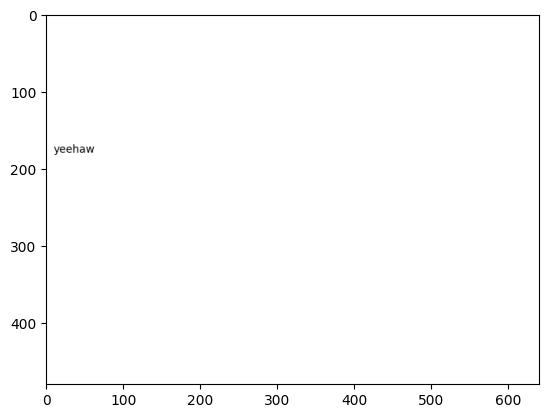

In [ ]:
canvas.draw()

plt.imshow(canvas.buffer_rgba())

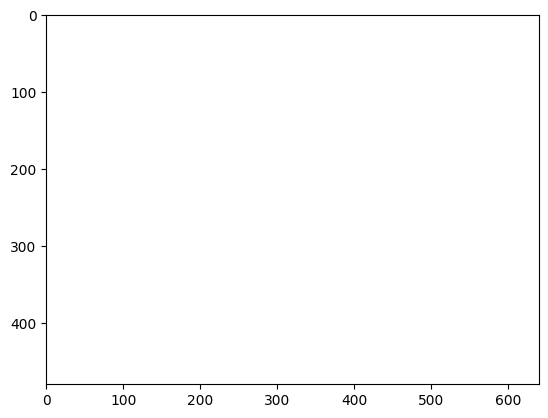

In [ ]:
plt.imshow(canvas.copy_from_bbox(fff.bbox))

In [ ]:
t = fff.text(0, 0, 'test')

In [ ]:
fff.get_tightbbox().y0

-0.03

In [ ]:
t.get_window_extent().y0

-3.0

In [ ]:
canvas.print_png('/tmp/testa.png')

In [ ]:
fff.canvas.tostring_rgb()

AttributeError: 'FigureCanvasAgg' object has no attribute 'renderer'

In [ ]:
plt.imshow(fff.canvas.buffer_rgba())

AttributeError: 'FigureCanvasAgg' object has no attribute 'renderer'

In [ ]:
c.fig.text

<bound method FigureBase.text of <Figure size 640x480 with 1 Axes>>

In [ ]:
%%timeit
c.fig.canvas.renderer

61.7 ns ± 1.24 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [15]:
sub.bbox.bounds

(0.0, 240.0, 320.0, 240.0)

In [16]:
fig.bbox.bounds

(0.0, 0.0, 640.0, 480.0)

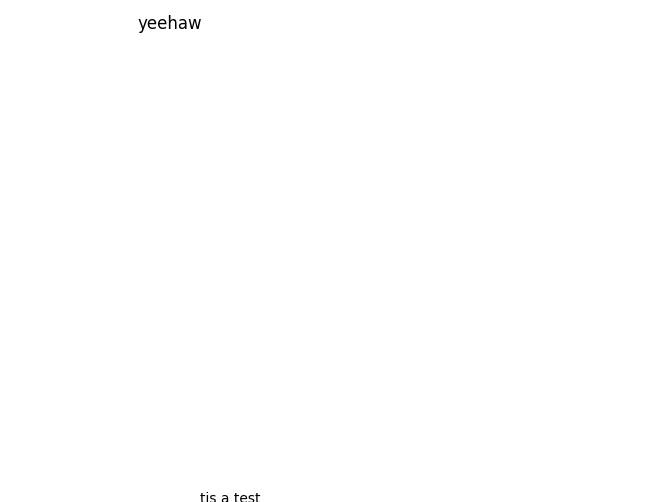

In [24]:
fig = plt.figure()
subfigs = fig.subfigures(2, 2)
sub = subfigs.flatten()[0]

sub.suptitle('yeehaw')

csub = Canvas(figure=sub)
csub.text(TextSpec('tis a test', size=None, position=Coordinate(200, 0), rotation=None))

plt.text(0, 0, '')
plt.show()

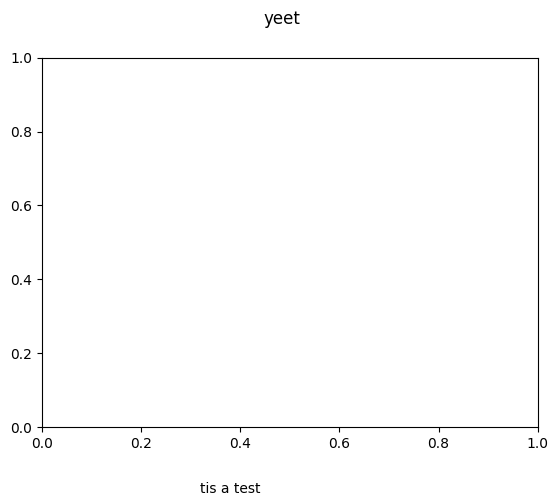

In [30]:
_f = plt.figure()

_f.suptitle('yeet')
Canvas(figure=_f).text(TextSpec('tis a test', size=None, position=Coordinate(200, 0), rotation=None))

plt.text(0, 0, '')
plt.show()

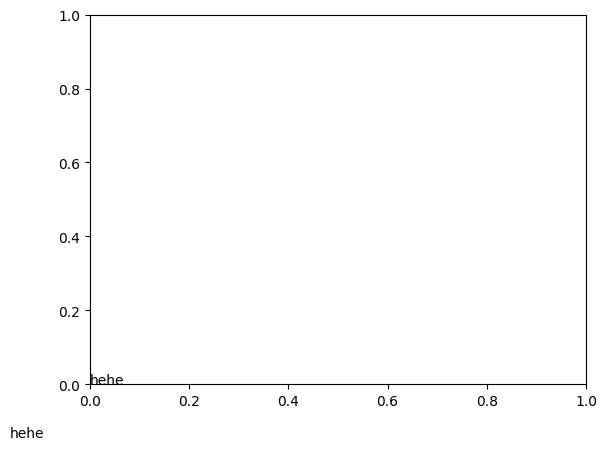

In [10]:

f = plt.figure()
plt.text(0, 0, 'hehe')
f.draw_artist(f.text(0, 0, 'hehe'))
plt.show()


In [5]:
mpl.backends.backend

'module://matplotlib_inline.backend_inline'

In [ ]:
fig.axes

[]

In [ ]:
f.axes

[<AxesSubplot: >]

TypeError: FigureBase.add_subfigure() missing 1 required positional argument: 'subplotspec'

In [21]:
ffff = mpl.figure.Figure(canvas=mpl.backends.backend_agg.FigureCanvas())


In [ ]:
ffff.dpi_scale_trans.inverted()

(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) None
(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)


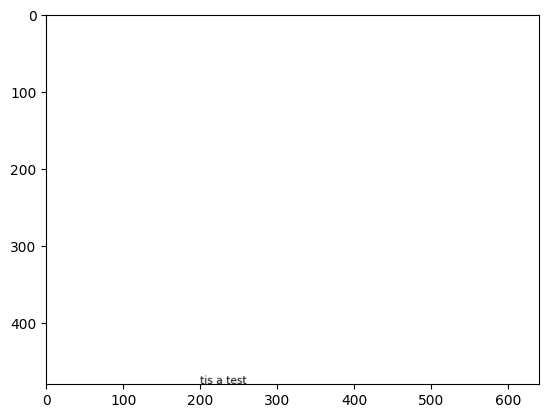

(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)
(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)


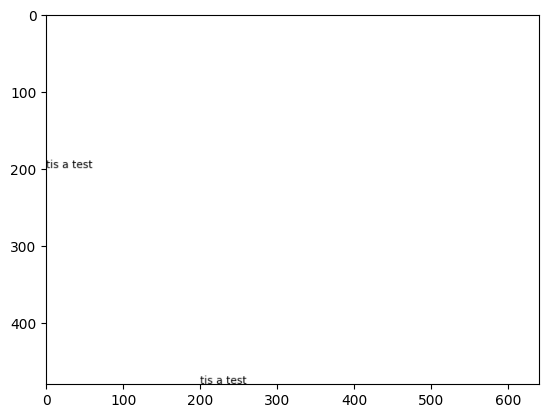

(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)


In [23]:

c = Canvas(figure=mpl.backends.backend_agg.FigureCanvas(figure=mpl.figure.Figure()).figure)

#c._ax.axis('off')

c_stats = lambda: print(c._base.figure.bbox.bounds, c._base.figure.canvas.figure.bbox.bounds, c._base.figure.canvas._lastKey)


c_stats()
#c.text(TextSpec('tis a test', size=None, position=(0, 0), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=None, position=(10, 10), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=None, position=(100, 100), rotation=None))
#c_stats()
#c.text(TextSpec('tis a test', size=None, position=(640 - 100, 480 - 100), rotation=None))
#c_stats()
c.text(TextSpec('tis a test', size=None, position=Coordinate(200, 0), rotation=None))
c_stats()
plt.imshow(c.data_rgba)
plt.show()

c.text(TextSpec('tis a test', size=None, position=Coordinate(0, 480 - 200), rotation=None))
c_stats()


c.data_rgba
c_stats()

plt.imshow(c.data_rgba)
plt.show()
c_stats()

(0.0, 0.0, 640.0, 480.0) (0.0, 0.0, 640.0, 480.0) (640.0, 480.0, 100.0)


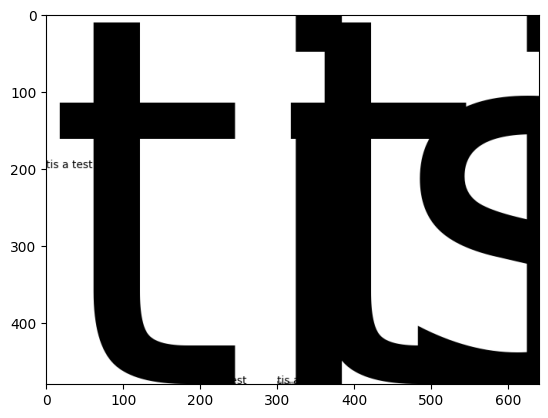

In [ ]:
c.text(TextSpec('tis a test', size=480, position=Coordinate(0, 0), rotation=None))
c_stats()
plt.imshow(c.data_rgba)
plt.show()

In [ ]:
%%timeit
_ = c.data_rgba

33.2 µs ± 286 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit
_ = c.data_bilevel

3.42 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%%timeit
c.fig.canvas.buffer_rgba()

292 ns ± 20 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


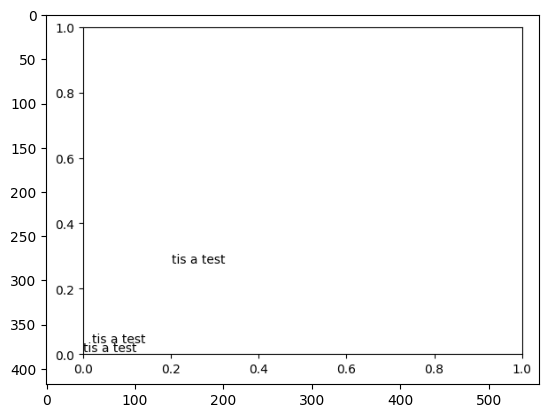

In [ ]:
#%%timeit
plt.imshow(c.fig.canvas.buffer_rgba())

In [ ]:
c.ax.bbox.x0, c.ax.bbox.x1

(80.0, 576.0)

In [ ]:
c.ax.bbox.y0, c.ax.bbox.y1

(52.8, 422.4)

In [ ]:
c.ax.bbox.x0

80.0

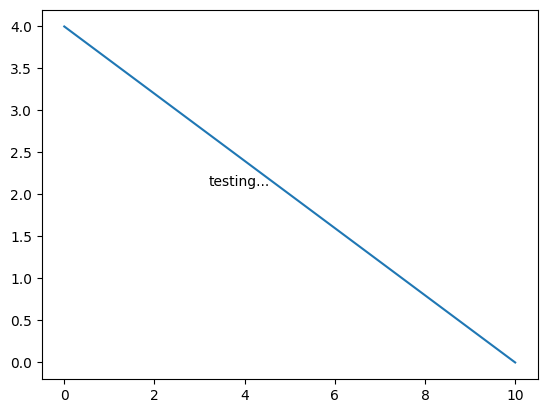

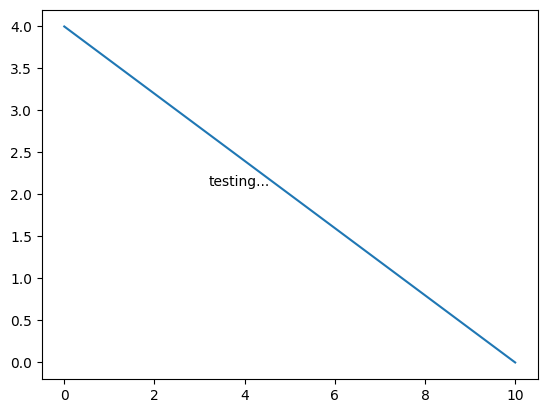

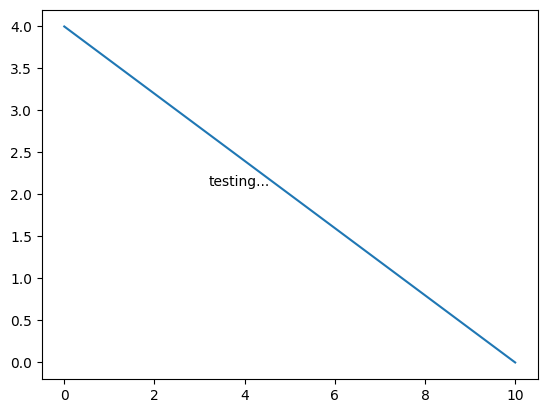

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure()
ax = f.add_subplot(111)
ax.plot([0,10], [4,0])

t = ax.text(3.2, 2.1, "testing...")
t.set_rotation('horizontal')

import copy

f_ = copy.deepcopy(t.figure)
t.figure

In [ ]:
f_.text(0, 0, 'haha')

Text(0, 0, 'haha')

In [ ]:
_ = f_

In [ ]:
f.bbox.bounds
f.canvas.figure.bbox.bounds

(0.0, 0.0, 640.0, 480.0)

In [ ]:
c.ax.get_tightbbox()

Bbox([[48.27777777777777, 29.077777777777776], [587.0, 427.9]])

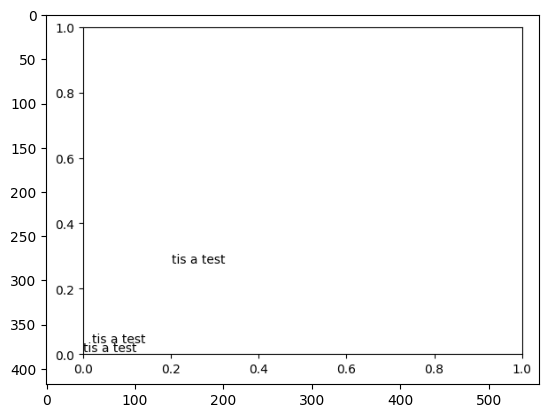

In [ ]:
plt.imshow(c._renderer.buffer_rgba())

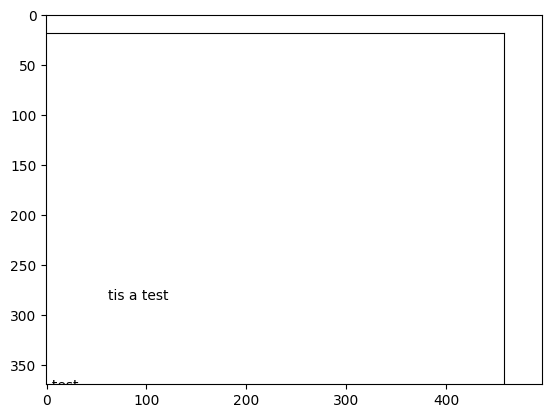

In [ ]:
plt.imshow(c.data_rgba)

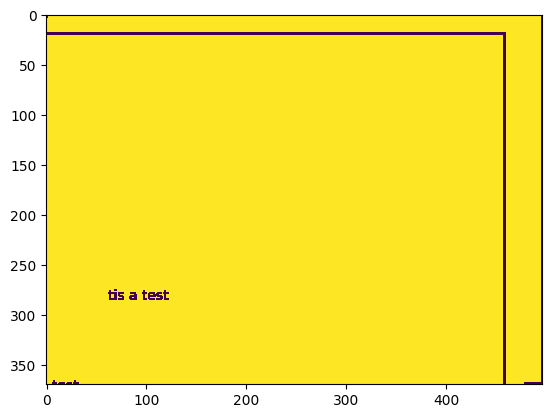

In [ ]:
plt.imshow(c.data_bilevel)

In [ ]:
%%timeit
#plt.imshow
(c.data_rgb)

(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)
(80.0, 52.8, 496.0, 369.59999999999997)


In [ ]:
c.fig.canvas.figure.bbox.size

array([640., 480.])

In [ ]:
c.fig.canvas._lastKey

(558.7222222222222, 418.82222222222214, 100.0)

(80.0, 52.8, 496.0, 369.59999999999997)


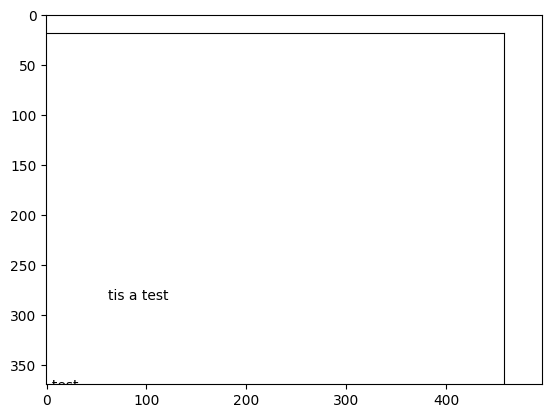

In [ ]:
plt.imshow(c.data_rgba)


(80.0, 52.8, 496.0, 369.59999999999997)


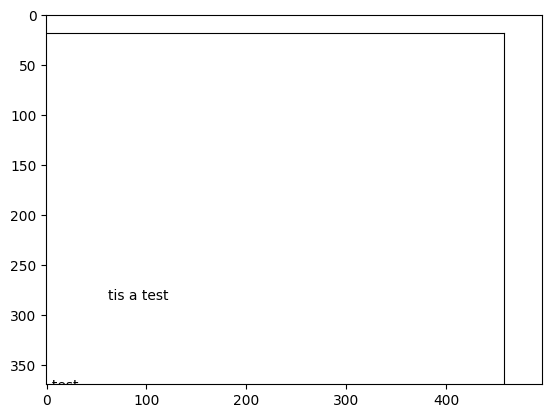

In [ ]:
plt.imshow(c.data_rgb)


20.1 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


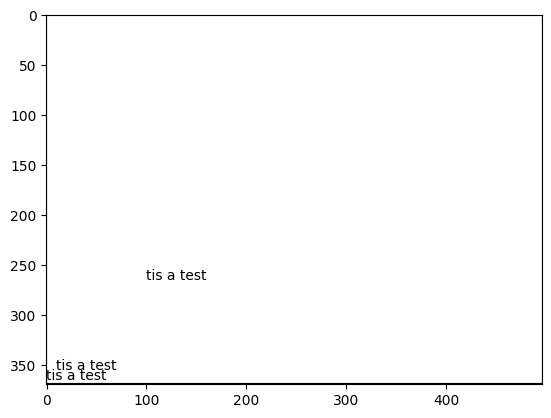

In [ ]:
%%timeit
plt.imshow(c.data_rgb)

In [ ]:
def _rgba_to_rgb(rgba, rgb_background):
    rgba = np.asarray(rgba, dtype=np.uint8)

    r, g, b, a = rgba.T
    r_, g_, b_, a_ = *rgb_background, a / 255.

    rgb = (a_ * (r, g, b) + (1 - a_) * (r, g, b)).T
    return rgb

def _rgb_to_bilevel(rgb, rgb_background):
    rgb, rgb_background = map(
        lambda x: np.asarray(x, dtype=np.uint8), 
        (rgb, rgb_background)
    )

    return (rgb == rgb_background).all(axis=-1)

In [ ]:
_rgba_to_rgb(c.data_rgba,  (255, 255, 255)).shape

(370, 496, 3)

In [ ]:
c.data_rgba[:2, :2]

array([[[255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0]]], dtype=uint8)

In [ ]:
_rgb_to_bilevel(_rgba_to_rgb(c.data_rgba[:2, :2],  (255, 255, 255)), (255, 255, 255)).all(axis=-1)


array([[ True,  True],
       [ True,  True]])

In [ ]:
r, g, b, a = c.data_rgba.T

In [ ]:
r.shape

(496, 370)

In [ ]:
np.asarray(
            c.data_rgba[[0], [0]],
            dtype=[('x', [
                ('r', np.uint8),
                ('g', np.uint8),
                ('b', np.uint8),
                ('a', np.uint8),
            ])
            ]
            #dtype=[
            #    ('x', [
            #        ('r', np.uint8),
            #        ('g', np.uint8),
            #        ('b', np.uint8),
            #        ('a', np.uint8),
            #    ]
            #    ),
            #    ('y', [
            #        ('r', np.uint8),
            #        ('g', np.uint8),
            #        ('b', np.uint8),
            #        ('a', np.uint8),
            #    ]
            #    )
            #]
        )

array([[((255, 255, 255, 255),), ((255, 255, 255, 255),),
        ((255, 255, 255, 255),), ((  0,   0,   0,   0),)]],
      dtype=[('x', [('r', 'u1'), ('g', 'u1'), ('b', 'u1'), ('a', 'u1')])])

In [ ]:
c.data_rgba[[0], [0]]

array([[255, 255, 255,   0]], dtype=uint8)

In [ ]:
c.data_rgba[0].shape

(496, 4)

In [ ]:
c.data_rgba.T.shape

(4, 496, 370)

In [ ]:
np.take(c.data_rgba, [0, 1, 2, 3], axis=2)

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

In [ ]:
c.data_rgba[0, 0]

array([255, 255, 255,   0], dtype=uint8)

In [ ]:
c.data_rgba

array([[[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       ...,

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        ...,
        [255, 255, 255,   0],
        [255, 255, 255,   0],
        [255, 255, 255,   0]],

       [[255

In [ ]:
np.asarray(
    c.data_rgba.T,
dtype=[
    ('r', np.uint8),
    ('g', np.uint8),
    ('b', np.uint8),
    ('a', np.uint8)
]    
)[['r', 'g']].shape


(4, 496, 370)

In [ ]:
c.data_rgba['g']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
c.data_rgba.shape

(370, 496, 4)

In [ ]:
np.squeeze(c.data_rgba.take([0, 1, 2, 3], axis=2)).shape


(370, 496, 4)

In [ ]:
c.ax.get_window_extent(c.fig.canvas.get_renderer()).bounds

(80.0, 52.8, 496.0, 369.59999999999997)

In [ ]:
bb = ax.get_tightbbox()

In [ ]:
ax.bbox

In [ ]:
fig.get_size_inches()

array([6.4, 4.8])

In [ ]:
ax.bbox.transformed(fig.dpi_scale_trans.inverted())

Bbox([[0.8, 0.528], [5.76, 4.224]])

In [ ]:
fig.bbox.transformed(fig.dpi_scale_trans.inverted())

Bbox([[0.0, 0.0], [6.4, 4.8]])

In [ ]:
bb.transformed(fig.dpi_scale_trans.inverted())

Bbox([[0.8, 0.528], [5.76, 4.224]])

In [ ]:
ax.get_tightbbox()

Bbox([[80.0, 52.8], [576.0, 422.4]])

In [ ]:
type(ax)

matplotlib.axes._subplots.AxesSubplot

In [ ]:
b = ax.get_window_extent()

In [ ]:
fig.get_window_extent().bounds

(0.0, 0.0, 640.0, 480.0)

In [ ]:
b.bounds

(80.0, 52.8, 496.0, 369.59999999999997)

In [ ]:
import importlib
importlib.reload(wordcloud)

<module 'wordcloud' from '/home/rexjo/.local/lib/python3.10/site-packages/wordcloud/__init__.py'>

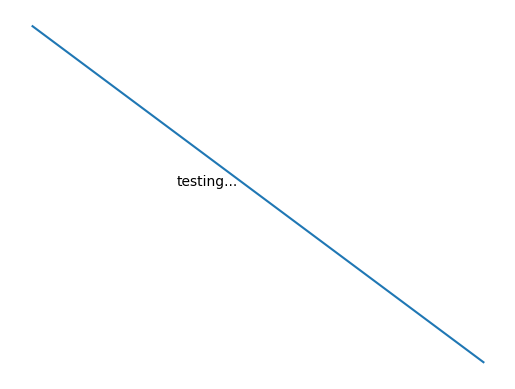

In [ ]:
import matplotlib.pyplot as plt

f = plt.figure()
ax = f.add_subplot(111)
ax.plot([0,10], [4,0])

ax.axis('off')

t = ax.text(3.2, 2.1, "testing...")
t.set_rotation('horizontal')

# get the inverse of the transformation from data coordinates to pixels
transf = ax.transData.inverted()
bb = t.get_window_extent(f.canvas.get_renderer())
bb_datacoords = bb.transformed(transf)

In [ ]:
canvas = f.canvas

In [ ]:
canvas.renderer.copy_from_bbox

<function RendererAgg.copy_from_bbox>

In [ ]:
canvas.copy_from_bbox

<bound method FigureCanvasAgg.copy_from_bbox of <matplotlib.backends.backend_agg.FigureCanvasAgg object at 0x7f75ada339a0>>

In [ ]:
canvas.copy_from_bbox(ax.bbox)

In [ ]:
aaa = f.canvas.copy_from_bbox(ax.bbox)

In [ ]:
np.array(aaa).shape

(370, 496, 4)

In [ ]:
np.squeeze(np.array(f.canvas.buffer_rgba()))

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [ ]:
f.get_window_extent().bounds

(0.0, 0.0, 640.0, 480.0)

In [ ]:
aaa.to_string_argb()

In [ ]:
type(aaa)

matplotlib.backends._backend_agg.BufferRegion

In [ ]:
aaa.get_extents()

(80, 58, 576, 428)

In [ ]:
_, _, width, height = aaa.get_extents()

In [ ]:
np.frombuffer(aaa.to_string_argb(), dtype=np.uint8).reshape(width, height, -1)

ValueError: cannot reshape array of size 734080 into shape (576,428,newaxis)

In [ ]:
734080/((576-4)*(428))

2.998496830272531

In [ ]:
734080/((3)*(428))


571.7133956386293

In [ ]:
_, _, width, height = aaa.get_extents()

(80, 58, 576, 428)

In [ ]:
ax.bbox.transformed(
                    f.dpi_scale_trans.inverted()
                )

Bbox([[0.8, 0.528], [5.76, 4.224]])

In [ ]:
ax.bbox.height

369.59999999999997

In [ ]:
f.bbox.height

480.0

In [ ]:
def fig2rgb_array(fig):
    fig.canvas.draw()
    buf = fig.canvas.tostring_rgb()
    ncols, nrows = fig.canvas.get_width_height()
    return np.frombuffer(buf, dtype=np.uint8).reshape(nrows, ncols, 3)

In [ ]:
fig2rgb_array(f)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:
import copy

In [ ]:
copy.copy(f).show()

AttributeError: Figure.show works only for figures managed by pyplot, normally created by pyplot.figure()

In [ ]:
f.draw(f.canvas.get_renderer())

In [ ]:
ax.get_window_extent().bounds

(80.0, 52.8, 496.0, 369.59999999999997)

In [ ]:
np.isnan(np.frombuffer(f.canvas.tostring_rgb())).all()

False

Bbox([[328.0, 233.59999999999997], [419.125, 251.59999999999997]])

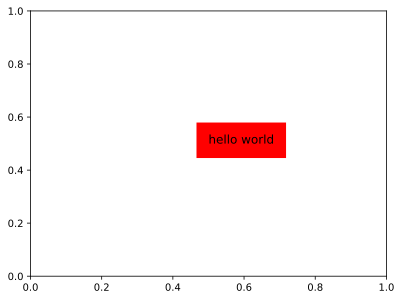

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
a = ax.text(0.5, 0.5, 'hello world', fontsize=12,
            #bbox=None
            #bbox=dict()
            bbox=dict(boxstyle='square,pad=1', fc='red', ec='none', visible=True)
    )
a.get_window_extent()

#plt.close()

In [ ]:
a.get_window_extent()

Bbox([[328.0, 235.10437499999998], [393.85375, 246.71812499999996]])

In [ ]:
a.get_tightbbox().bounds


(328.0, 235.10437499999998, 65.85374999999999, 11.613749999999982)

In [ ]:
a.get_bbox_patch().get_extents() #== a.get_bbox_patch().get_window_extent()

Bbox([[196.663125, 142.4385], [286.516875, 178.05225000000002]])

In [ ]:
a.get_bbox_patch().get_window_extent()

Bbox([[196.663125, 142.4385], [286.516875, 178.05225000000002]])

In [ ]:
a.get_bbox_patch().get_bbox()

Bbox([[0.0, 0.0], [65.85374999999999, 11.61375]])

In [ ]:
t.get_bbox_patch()

In [ ]:
bb

Bbox([[1667.2, 825.9599999999999], [1728.45, 839.9599999999999]])

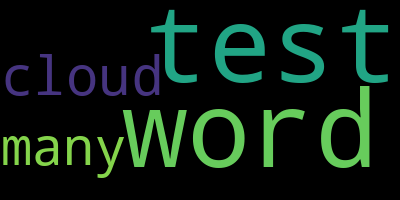

In [ ]:
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
def set_constrained_layout(plt):
    plt.rcParams['figure.constrained_layout.use'] = True
set_constrained_layout(plt)

plt.style.use('default')

import wordcloud

display(wordcloud.WordCloud().generate('this is a test word cloud and many more').to_image())

In [ ]:
dir(wordcloud)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'generate_from_frequencies']

In [ ]:
import wordcloud

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

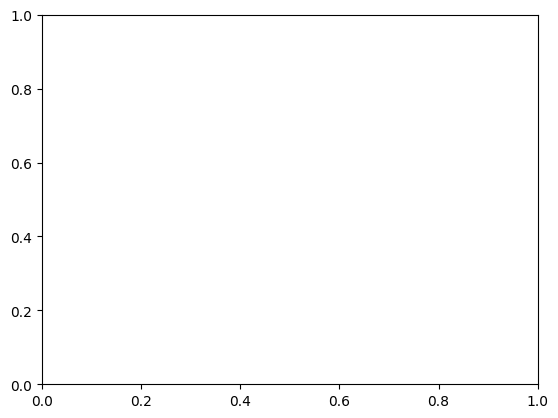

In [ ]:
import matplotlib.pyplot as plt
plt.subplots()

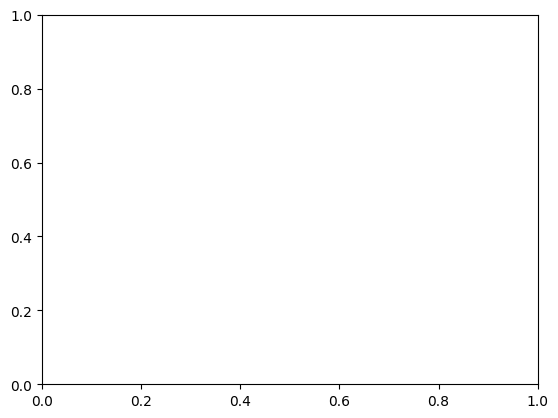

In [ ]:
ax.transData

Text(0.5, 0.5, 'Test 1')

Text(50, 5, 'Test 1')

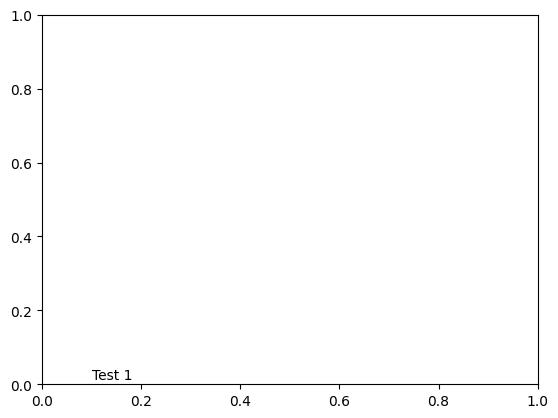

In [ ]:
ax = plt.gca()

#ax.text(5, 5, 'matplotlib')
ax.annotate("Test 1", xy=(50, 5), xycoords='axes pixels')


In [ ]:
ax.transData.transform([0.5, .5])

array([328. , 237.6])

In [ ]:
random.choice((True, False))

True

In [ ]:
random.sample(iter([1, 2, 3]), 6)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [ ]:
import random

In [ ]:
random.Random()

In [ ]:
import numpy as np


def query_integral_image(
    integral_image, 
    size_x, size_y
):
    x, y = np.shape(integral_image)

    # count how many possible locations
    for i in range(x - size_x):
        for j in range(y - size_y):
            area = integral_image[i, j] + integral_image[i + size_x, j + size_y]
            area -= integral_image[i + size_x, j] + integral_image[i, j + size_y]
            if not area:
                yield i, j